In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
Y_train = pd.read_csv('../data/Y_train.csv')
Y_test = pd.read_csv('../data/Y_test.csv')

# Decision Tree Regression

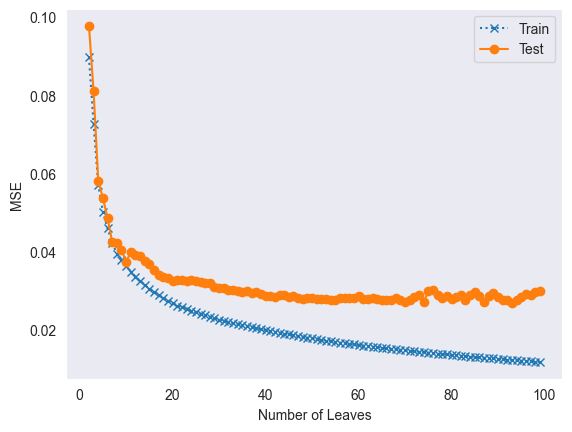

In [17]:
errors = []

for max_leaves in range(2,100):
    # train and predict
    dt = DecisionTreeRegressor(max_leaf_nodes=max_leaves)
    dt.fit(X_train,Y_train)

    # compute Accuracy
    train_acc = mean_squared_error(y_true=Y_train, y_pred=dt.predict(X_train))
    test_acc  = mean_squared_error(y_true=Y_test,  y_pred=dt.predict(X_test))

    errors += [ [max_leaves, train_acc, test_acc] ]

errors = np.array(errors)

fig, ax = plt.subplots()
ax.plot(errors[:,0], errors[:,1], "x:", label="Train")
ax.plot(errors[:,0], errors[:,2], "o-", label="Test")
ax.set_ylabel("MSE")
ax.set_xlabel("Number of Leaves")
ax.grid()
ax.legend();

In [18]:
# it seems that around 20 as max_leaves parameter the test becomes worse than the train. Let's see what MSE we have when max_leaves=20

dt = DecisionTreeRegressor(max_leaf_nodes=20)
dt.fit(X_train,Y_train)

train_pre = dt.predict(X_train)
test_pre = dt.predict(X_test)

print("Train MSE: {:.3f}".format(mean_squared_error(y_true=np.exp(Y_train), y_pred=np.exp(train_pre)) ))
print("Train MSE: {:.3f}".format(mean_squared_error(y_true=np.exp(Y_test),  y_pred=np.exp(test_pre)) ))

print("Train R^2: {:.3f}".format(r2_score(y_true=np.exp(Y_train), y_pred=np.exp(train_pre)) ))
print("Train R^2: {:.3f}".format(r2_score(y_true=np.exp(Y_test),  y_pred=np.exp(test_pre)) ))

Train MSE: 953931998.951
Train MSE: 1201335104.289
Train R^2: 0.840
Train R^2: 0.851


In [19]:
# it seems that around 20 as max_leaves parameter the test becomes worse than the train. Let's see what MSE we have when max_leaves=19

dt = DecisionTreeRegressor(max_leaf_nodes=19)
dt.fit(X_train,Y_train)

train_pre = dt.predict(X_train)
test_pre = dt.predict(X_test)

print("Train MSE: {:.3f}".format(mean_squared_error(y_true=np.exp(Y_train), y_pred=np.exp(train_pre)) ))
print("Train MSE: {:.3f}".format(mean_squared_error(y_true=np.exp(Y_test),  y_pred=np.exp(test_pre)) ))

print("Train R^2: {:.3f}".format(r2_score(y_true=np.exp(Y_train), y_pred=np.exp(train_pre)) ))
print("Train R^2: {:.3f}".format(r2_score(y_true=np.exp(Y_test),  y_pred=np.exp(test_pre)) ))

Train MSE: 972741226.003
Train MSE: 1220698490.983
Train R^2: 0.837
Train R^2: 0.849


These results aren't satisfactory because the Mean Squared Error is very high both in the training phase and in the test phase

Text(0, 0.5, 'Sale_Price')

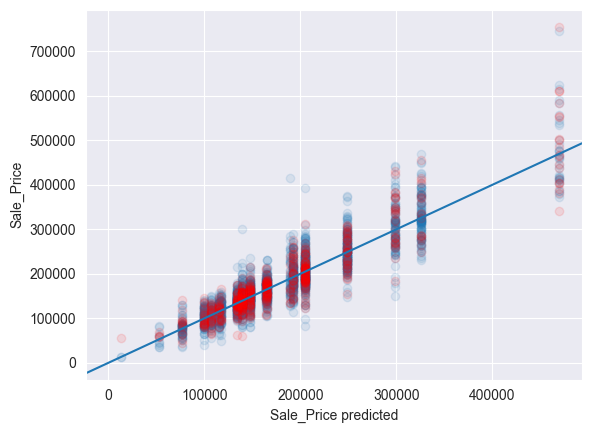

In [20]:
fig, axs = plt.subplots()

axs.plot(np.exp(train_pre), np.exp(Y_train), 'o', alpha=0.1)
axs.plot(np.exp(test_pre), np.exp(Y_test), 'o', alpha=0.1, c="red")
axs.axline((0, 0), slope=1)
axs.set_xlabel('Sale_Price predicted')
axs.set_ylabel('Sale_Price')